In [107]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.io as torchio
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.datasets as tds
import pandas as pd
import PIL

from google.colab import drive
drive.mount('/content/drive')

torch.manual_seed(42)

# Address for Datasets within the Drive
truthPath = "/content/drive/My Drive/data/baseline_data/animations/anim1/4096/"
noisyPath = "/content/drive/My Drive/data/baseline_data/animations/anim1/1/"

class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, truth_dir, noisy_dir, transform=None):
        """
        transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.truth_paths = [os.path.join(truth_dir, f) for f in os.listdir(truth_dir)]
        self.noisy_paths = [os.path.join(noisy_dir, f) for f in os.listdir(noisy_dir)]
        assert len(self.truth_paths) == len(self.noisy_paths)
        self.transform = transform

    def __len__(self):
        return len(self.truth_paths)

    def __getitem__(self, idx):
      sample = [
        torchio.read_image(self.noisy_paths[idx], torchio.ImageReadMode.RGB),
        torchio.read_image(self.truth_paths[idx], torchio.ImageReadMode.RGB)]

      if (self.transform):
        sample = self.transform(sample)
        assert len(sample) == 2

      return sample

class FiltersImagesDataset(ImagesDataset):
    def __getitem__(self, idx):
      noisy = cv2.cvtColor(cv2.imread(self.noisy_paths[idx]), cv2.COLOR_BGR2RGB)
      mf = cv2.medianBlur(noisy, 5)
      nlm = cv2.fastNlMeansDenoisingColored(noisy, None, 10, 10, 7, 21)
      truth = cv2.cvtColor(cv2.imread(self.truth_paths[idx]), cv2.COLOR_BGR2RGB)

      noisy = torch.from_numpy(noisy)
      mf = torch.from_numpy(mf)
      nlm = torch.from_numpy(nlm)
      truth = torch.from_numpy(truth)
      sample = [noisy, mf, nlm, truth]

      if (self.transform):
        sample = self.transform(sample)
        assert len(sample) == 4

      return sample

ds = FiltersImagesDataset(truthPath, noisyPath)
data_loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=2)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


True

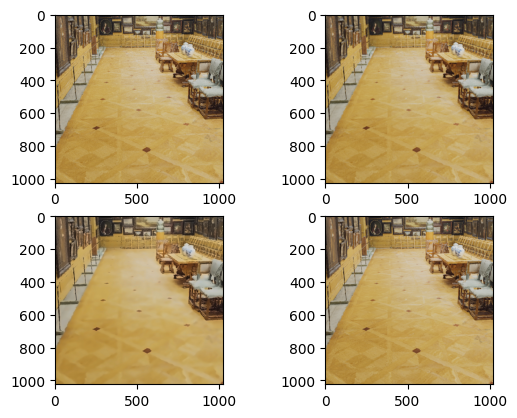

In [112]:
# Demonstrates the filters
noisy_torch, mf_torch, nlm_torch, truth_torch = next(iter(data_loader))
noisy_torch = noisy_torch[0].to(torch.int32)
mf_torch = mf_torch[0].to(torch.int32)
nlm_torch = nlm_torch[0].to(torch.int32)
truth_torch = truth_torch[0].to(torch.int32)

noisy = np.array(noisy_torch)
mf = np.array(mf_torch)
nlm = np.array(nlm_torch)
truth = np.array(truth_torch)

plt.subplot(221),plt.imshow(noisy)
plt.subplot(222),plt.imshow(mf)
plt.subplot(223),plt.imshow(nlm)
plt.subplot(224),plt.imshow(truth)

# Convert back to BGR for cv2
noisy = noisy[..., ::-1]
mf = mf[..., ::-1]
nlm = nlm[..., ::-1]
truth = truth[..., ::-1]

cv2.imwrite("/content/drive/My Drive/baseline output/noisy.jpg", noisy)
cv2.imwrite("/content/drive/My Drive/baseline output/mf.jpg", mf)
cv2.imwrite("/content/drive/My Drive/baseline output/nlm.jpg", nlm)
cv2.imwrite("/content/drive/My Drive/baseline output/truth.jpg", truth)

In [110]:
print(noisy.shape)

(1024, 1024, 3)


In [91]:
criterion = nn.MSELoss()
print("Noisy vs Truth MSE: ", criterion(noisy_torch, truth_torch))
print("MF vs Truth MSE: ", criterion(mf_torch, truth_torch))
print("NLM vs Truth MSE: ", criterion(nlm_torch, truth_torch))

Noisy vs Truth MSE:  tensor(155.6529)
MF vs Truth MSE:  tensor(86.8116)
NLM vs Truth MSE:  tensor(117.1627)


In [96]:
# mse = np.mean(cv2.absdiff(noisy, truth) ** 2)
# print("mse: ", mse)
noisy_mse = []
mf_mse = []
nlm_mse = []
for i, sample in enumerate(data_loader):
  print("iteration: ", i)
  noisy_mse.append(float(criterion(sample[0][0], sample[3][0])))
  mf_mse.append(float(criterion(sample[1][0], sample[3][0])))
  nlm_mse.append(float(criterion(sample[2][0], sample[3][0])))


iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50
iteration:  51
iteration:  52
iteration:  53
iteration:  54
iteration:  55
iteration:  56
iteration:  57
iteration:  58
iteration:  59
iteration:  60
iteration:  61
iteration:  62
iteration:  63
iteration:  64
iteration:  65
iteration:  66
itera

In [97]:
print("first noisy mse: ", noisy_mse[0])
print("first mf mse: ", mf_mse[0])
print("first nlm mse: ", nlm_mse[0])
print("average noisy mse: ", sum(noisy_mse) / len(noisy_mse))
print("average mf mse: ", sum(mf_mse) / len(mf_mse))
print("average nlm mse: ", sum(nlm_mse) / len(nlm_mse))

first noisy mse:  155.65293884277344
first mf mse:  86.8116226196289
first nlm mse:  117.16265106201172
average noisy mse:  150.41511462402343
average mf mse:  87.6341962890625
average nlm mse:  110.77418902587891
